# Uncovering Healthcare Inefficiencies - Model Building and Evaluation

This notebook focuses on building, training, and evaluating various models to determine the best performing model for our dataset.

The models included in this notebook are:

1. **Logistic Regression**: Used as the baseline model.
2. **Ridge Classifier**: Classification model using L2 regularization.
3. **Lasso Classifier**: Classification model using L1 regularization.
4. **XGBoost**: Powerful gradient boosting framework.
5. **Agglomerative Clustering**: Hierarchical clustering method.
6. **DBSCAN**: Unsupervised clustering to identify clusters and noise.
7. **Kmeans**: Another unsupervised clustering to identify clusters and noise.

Each model undergoes the following steps:

1. **Data Preprocessing**: Standardizing and preparing data.
2. **Model Building**: Constructing model architecture.
3. **Model Training**: Training the model.
4. **Model Evaluation**: Assessing performance.
5. **Results Analysis**: Comparing results to determine the best model.


The objective is to identify the model that yields the best results in terms of accuracy and other relevant metrics. 

## Import Libaries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.cluster.hierarchy import linkage

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import PowerTransformer, RobustScaler

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV,  KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, roc_curve, auc
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

import joblib

from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # supress warning 

In [2]:
# Check current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: C:\Users\jessh\Documents\MS_Applied_Data_Science\ADS599 Capstone Project\Project


#### Import data from preprocessing notebook

In [3]:
# Read in data
# all the training/validation/test dataframes
x_train = pd.read_csv('data/x_train.csv') 
x_train_scaled = pd.read_csv('data/x_train_scaled.csv')
x_train_pca = pd.read_csv('data/x_train_pca.csv')
x_train_scaled_pca = pd.read_csv('data/x_train_scaled_pca.csv')

x_val = pd.read_csv('data/x_val.csv') 
x_val_scaled = pd.read_csv('data/x_val_scaled.csv')
x_val_pca = pd.read_csv('data/x_val_pca.csv')
x_val_scaled_pca = pd.read_csv('data/x_val_scaled_pca.csv')

x_test = pd.read_csv('data/x_test.csv')
x_test_scaled = pd.read_csv('data/x_test_scaled.csv')
x_test_pca = pd.read_csv('data/x_test_pca.csv')
x_test_scaled_pca = pd.read_csv('data/x_test_scaled_pca.csv')


# all the labels
y_train = np.ravel(pd.read_csv('data/y_train.csv'))
y_val = np.ravel(pd.read_csv('data/y_val.csv'))
y_test = np.ravel(pd.read_csv('data/y_test.csv'))

## DataTransformation 

### Yeo Johnson transformation of data

We wanted to add in additional dataframes to see if there was a difference in modeling performance. This Yeo-Johnson transformation was one of them, another would be to do transformation + scaling.

In [ ]:
# transformed data
# create copy of df 
x_train_transformed = x_train.copy()
x_val_transformed = x_val.copy()
x_test_transformed = x_test.copy()

# get numeric columns
numeric_columns = x_train_transformed.select_dtypes(include=['float']).columns

def yeo_johnson_transform(column):
    # Create an instance of PowerTransformer with Yeo-Johnson method
    pt = PowerTransformer(method='yeo-johnson')
    
    # Reshape column for PowerTransformer which expects 2D input
    column_reshaped = column.values.reshape(-1, 1)
    
    # Fit and transform the column
    transformed_col = pt.fit_transform(column_reshaped)
    
    # Flatten the result to match original column shape
    return transformed_col.flatten()

# Apply Box-Cox transformation to each numeric column
for col in numeric_columns:
    x_train_transformed[col] = yeo_johnson_transform(x_train_transformed[col])
    x_val_transformed[col] = yeo_johnson_transform(x_val_transformed[col])
    x_test_transformed[col] = yeo_johnson_transform(x_test_transformed[col])


### Log transformed + scaled data

In [ ]:
x_train_trans_scaled = x_train_transformed.copy()
x_val_trans_scaled = x_val_transformed.copy()
x_test_trans_scaled = x_test_transformed.copy()

scaler = RobustScaler()
x_train_trans_scaled[numeric_columns] = scaler.fit_transform(x_train_trans_scaled[numeric_columns])
x_val_trans_scaled[numeric_columns] = scaler.transform(x_val_trans_scaled[numeric_columns])
x_test_trans_scaled[numeric_columns] = scaler.transform(x_test_trans_scaled[numeric_columns])

## Baseline Model Selection - Logistic Regression

We'll first start by deciding on a baseline model for comparison against other models. The confusion matrix will be used to determine which dataframe will be ingested for each machine learning model. We currently have the following dataframes/data to feed into the logistic regression model:

* The preprocessed data - x_train
* The transformed data - x_train_tranformed
* The scaled data - x_train_scaled
* The transformed + scaled data - x_train_trans_scaled
* The pca transformed data - x_train_pca
* The scaled data + pca - x_train_scaled_pca

Based on the results of the baseline regression model, we can choose a dataframe to carry through the modeling process.

### Create and train Logistic Regression Model for unscaled data

This is the first model with the data that has been preprocessed but not scaled nor transformed for normality. The accuracy was terrible, the precision and F-score were non existant.

In [ ]:
# logreg model
model = LogisticRegression()

# Train the model
model.fit(x_train, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(x_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

### Create and train Logistic Regression Model for the scaled data

This is the first model with the data that has been preprocessed and scaled, but not transformed for normality. The accuracy was 100%, leading us to believe that the model is overfit.

In [ ]:
# logreg model
model = LogisticRegression()

# Train the model
model.fit(x_train_scaled, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(x_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = model.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

### Create and train Logistic Regression Model for yeo-johnson transformed data

This is the first model with the data that has been preprocessed and transformed, but not scaled. The accuracy was 100%, leading us to believe that the model is also overfit.

In [ ]:
# logreg model
model = LogisticRegression()

# Train the model
model.fit(x_train_transformed, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(x_val_transformed)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = model.predict(x_test_transformed)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

### Create and train Logistic Regression Model for yeo-johnson transformed and scaled data

This is the first model with the data that has been preprocessed, scaled, and transformed for normality. The accuracy was 100%, leading us to believe that the model is also overfit.

In [ ]:
# logreg model
model = LogisticRegression()

# Train the model
model.fit(x_train_trans_scaled, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(x_val_trans_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = model.predict(x_test_trans_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

### Create and train Logistic Regression Model for the PCA transformed data (orig)

This is the fifth model with the data that has been preprocessed, but not scaled nor transformed for normality. The accuracy was about 81%, which is the best model so far.

In [ ]:
# logreg model
model = LogisticRegression()

# Train the model
model.fit(x_train_pca, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(x_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = model.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

### Create and train Logistic Regression Model for the PCA transformed data (scaled)

This is the sixth model with the data that has been preprocessed and scaled, but not transformed for normality. The accuracy was about 82%, which is the best model so far beating the previous model.

In [6]:
# logreg model
logreg_model = LogisticRegression(random_state = 42)

# Train the model
logreg_model.fit(x_train_scaled_pca, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_scaled_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_scaled_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 0.8236739800706019
Validation Confusion Matrix:
[[107864   8967]
 [ 18655  21167]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116831
           1       0.70      0.53      0.61     39822

    accuracy                           0.82    156653
   macro avg       0.78      0.73      0.75    156653
weighted avg       0.81      0.82      0.81    156653

Test Accuracy: 0.82516245994357
Test Confusion Matrix:
[[108066   8766]
 [ 18623  21199]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116832
           1       0.71      0.53      0.61     39822

    accuracy                           0.83    156654
   macro avg       0.78      0.73      0.75    156654
weighted avg       0.82      0.83      0.82    156654



We opted to use PCA-transformed and scaled data for creating and training our Logistic Regression model for several compelling reasons:

1. **Dimensionality Reduction**:
   - **Principal Component Analysis (PCA)** is a powerful technique used to reduce the dimensionality of our dataset while retaining the most important information. This helps in eliminating redundant and less informative features, leading to a more efficient and interpretable model.

2. **Feature Scaling**:
   - Scaling our data ensures that all features contribute equally to the model. Logistic Regression, like many machine learning algorithms, performs better when the data is normalized, preventing features with larger scales from dominating the model training process.

3. **Model Performance**:
   - The Logistic Regression model trained on PCA-transformed and scaled data achieved an accuracy of about 82%. This is a significant improvement over previous models and is currently our best-performing model. The use of PCA likely helped in capturing the underlying structure of the data more effectively.

4. **Overfitting Reduction**:
   - By reducing the number of features, PCA helps in minimizing the risk of overfitting. Overfitting occurs when the model is too complex and captures noise in the data, rather than the actual underlying pattern. PCA helps in addressing this by simplifying the feature set.

5. **Computational Efficiency**:
   - With fewer features after PCA, the computational cost of training the Logistic Regression model decreases. This makes the model training process faster and more resource-efficient, which is particularly beneficial when dealing with large datasets.

Using PCA-transformed and scaled data has led to a significant improvement in model accuracy and overall performance, justifying our decision to incorporate these preprocessing steps in our modeling pipeline. The 82% accuracy stands as evidence to the effectiveness of this approach.


## Accuracy Scores for supervised models

| Model | Parameters | Dataset | Accuracy |
| --- | --- | --- | --- |
| Ridge | Default | 5-Fold Validation | 0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned | Validation |   0.82 |
|  | Test | Test |  0.83 |
| Lasso | Default | 5-Fold Validation |  0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned | Single Validation |  0.82 |
|  | Tuned | Test |  0.83 |
| XGBoost | Tuned | Validation |  0.88 |
|  | Tuned | Test |  0.88 |
| Agglomerative Clustering | Tuned | Validation |  0.74 |
|  | Tuned | Test |  0.73 |
| DBSCAN | Tuned | Validation |  0.74 |
|  | Tuned | Test |  0.73 |
| AdaBoost | Default | Validation |  0.76 |
|  | Default | Test |  0.76 |
| SVM | Default | Validation |  0.84 |
|  | Default | Test |  0.85 |



The best model would be the XGboost model with a 88% accuracy. This will be the model that will be deployed with flask. The code below documents how we built the model and tuned parameters for each model.

## XGBoost 

In [ ]:
# define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


# initialize the XGBoost classifier
xgb_model = XGBClassifier()

# setup GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, 
                               param_grid=param_grid_xgb, 
                               scoring='accuracy', 
                               cv=3, n_jobs=2, verbose=2)

In [ ]:
# fit the model
grid_search_xgb.fit(x_train_scaled_pca, y_train)

In [ ]:
# best parameters and best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print(f'Best Parameters for XGBoost: {best_params_xgb}')
print(f'Best Cross-Validation Score: {best_score_xgb}')

In [ ]:
# evaluate on validation set
xgb_best_model = grid_search_xgb.best_estimator_
y_val_pred = xgb_best_model.predict(x_val_scaled_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'XGBoost Validation Accuracy: {val_accuracy}')
print('XGBoost Validation Confusion Matrix:')
print(val_confusion_matrix)
print('XGBoost Validation Classification Report:')
print(val_classification_report)

In [ ]:
# evaluate on test set
y_test_pred = xgb_best_model.predict(x_test_scaled_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'XGBoost Test Accuracy: {test_accuracy}')
print('XGBoost Test Confusion Matrix:')
print(test_confusion_matrix)
print('XGBoost Test Classification Report:')
print(test_classification_report)

In [ ]:
# plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_best_model, importance_type='weight')
plt.title('Feature Importance for XGBoost Model')
plt.show()

In [ ]:
# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned XGBoost model
xgb_best_model_path = 'xgb_best_model.joblib'
joblib.dump(xgb_best_model, xgb_best_model_path)

print(f'Tuned XGBoost model saved at: {xgb_best_model_path}')

##  Agglomerative Clustering

In [ ]:
# reduce datasize for agglomerative clustering and DBSCAN 

# function to reduce dataset size
def reduce_dataset(x, y, sample_size):
    np.random.seed(42)
    indices = np.random.choice(x.shape[0], size=sample_size, replace=False)
    return x[indices], y[indices]

# convert data to np.float32
x_train_np = x_train_scaled_pca.astype(np.float32).to_numpy()
x_val_np = x_val_scaled_pca.astype(np.float32).to_numpy()
x_test_np = x_test_scaled_pca.astype(np.float32).to_numpy()

# sample the data
sample_size = 25000
x_train_sampled, y_train_sampled = reduce_dataset(x_train_np, y_train, sample_size)
x_val_sampled, y_val_sampled = reduce_dataset(x_val_np, y_val, sample_size)
x_test_sampled, y_test_sampled = reduce_dataset(x_test_np, y_test, sample_size)

In [ ]:
# define the parameter grid for the number of clusters
param_grid_agg = {'n_clusters': [2, 3, 4, 5, 6]}

# initialize the AgglomerativeClustering model
agg_model = AgglomerativeClustering()

# define a custom scoring function using silhouette score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

# setup GridSearchCV with silhouette scorer
grid_search_agg = GridSearchCV(estimator=agg_model, param_grid=param_grid_agg, 
                               scoring=silhouette_scorer, cv=3, n_jobs=-2, verbose=2)


In [ ]:
# fit the model
grid_search_agg.fit(x_train_sampled)

In [ ]:
# best parameters and best score
best_params_agg = grid_search_agg.best_params_
best_score_agg = grid_search_agg.best_score_

print(f'Best Parameters for Agglomerative Clustering: {best_params_agg}')
print(f'Best Cross-Validation Score: {best_score_agg}')

In [ ]:
# evaluate on validation set
agg_best_model = grid_search_agg.best_estimator_
y_val_pred = agg_best_model.fit_predict(x_val_sampled)
val_accuracy = accuracy_score(y_val_sampled, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val_sampled, y_val_pred)
val_classification_report = classification_report(y_val_sampled, y_val_pred)

print(f'Agglomerative Clustering Validation Accuracy: {val_accuracy}')
print('Agglomerative Clustering Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Agglomerative Clustering Validation Classification Report:')
print(val_classification_report)

In [ ]:
# evaluate on test set
y_test_pred = agg_best_model.fit_predict(x_test_sampled)
test_accuracy = accuracy_score(y_test_sampled, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test_sampled, y_test_pred)
test_classification_report = classification_report(y_test_sampled, y_test_pred)

print(f'Agglomerative Clustering Test Accuracy: {test_accuracy}')
print('Agglomerative Clustering Test Confusion Matrix:')
print(test_confusion_matrix)
print('Agglomerative Clustering Test Classification Report:')
print(test_classification_report)

In [ ]:
# compute the silhouette scores for each sample
agglo_labels = y_val_pred 
silhouette_avg_agglo = silhouette_score(x_val_sampled, agglo_labels)
sample_silhouette_values_agglo = silhouette_samples(x_val_sampled, agglo_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# silhouette coefficient - focus on 0 to 1
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(x_val_sampled) + (len(np.unique(agglo_labels)) + 1) * 10])

y_lower = 10
for i in range(len(np.unique(agglo_labels))):
    ith_cluster_silhouette_values = sample_silhouette_values_agglo[agglo_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(np.unique(agglo_labels)))
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # compute  new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette plot for Agglomerative Clustering")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg_agglo, color="red", linestyle="--")

ax1.set_yticks([]) 
ax1.set_xticks(np.arange(-0.1, 1.1, 0.1))

plt.show()

In [ ]:
# save tuned Agglomerative Clustering model
agg_best_model_path = 'models/agg_best_model.pkl'
joblib.dump(agg_best_model, agg_best_model_path)

print(f'Tuned Agglomerative Clustering model saved at: {agg_best_model_path}')

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

In [ ]:
# define silhouette scorer
class SilhouetteScorer:
    def __init__(self, X):
        self.X = X

    def __call__(self, estimator, X=None):
        labels = estimator.fit_predict(self.X)
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if num_clusters > 1:
            return silhouette_score(self.X, labels)
        else:
            return -1 
        
# define the parameter grid for DBSCAN
param_grid_dbscan = {
    'eps': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'min_samples': [3, 5, 7, 10, 15]
}

# initialize the DBSCAN model
dbscan_model = DBSCAN()

# create the silhouette scorer
silhouette_scorer = SilhouetteScorer(X=x_train_sampled)

# setup GridSearchCV
grid_search_dbscan = GridSearchCV(estimator=dbscan_model, param_grid=param_grid_dbscan, 
                                  scoring=silhouette_scorer, cv=3, n_jobs=-1, verbose=2)

In [ ]:
# fit the model
grid_search_dbscan.fit(x_train_sampled)

In [ ]:
# best parameters and best score
best_params_dbscan = grid_search_dbscan.best_params_
best_score_dbscan = grid_search_dbscan.best_score_

print(f'Best Parameters for DBSCAN: {best_params_dbscan}')
print(f'Best Cross-Validation Score: {best_score_dbscan}')

In [ ]:
# evaluate on validation set
dbscan_best_model = grid_search_dbscan.best_estimator_
y_val_pred = dbscan_best_model.fit_predict(x_val_sampled)

In [ ]:
# calculate silhouette score
silhouette_avg = silhouette_score(x_val_sampled, y_val_pred)

print(f'DBSCAN Validation Silhouette Score: {silhouette_avg}')

val_accuracy = accuracy_score(y_val_sampled, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val_sampled, y_val_pred)
val_classification_report = classification_report(y_val_sampled, y_val_pred, zero_division=0)

print(f'DBSCAN Validation Accuracy: {val_accuracy}')
print('DBSCAN Validation Confusion Matrix:')
print(val_confusion_matrix)
print('DBSCAN Validation Classification Report:')
print(val_classification_report)

In [ ]:
# evaluate on test set
y_test_pred = dbscan_best_model.fit_predict(x_test_sampled)
test_accuracy = accuracy_score(y_test_sampled, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test_sampled, y_test_pred)
test_classification_report = classification_report(y_test_sampled, y_test_pred, zero_division=0)

# calculate silhouette score
silhouette_avg = silhouette_score(x_test_sampled, y_test_pred)

print(f'DBSCAN Validation Silhouette Score: {silhouette_avg}')

print(f'DBSCAN Test Accuracy: {test_accuracy}')
print('DBSCAN Test Confusion Matrix:')
print(test_confusion_matrix)
print('DBSCAN Test Classification Report:')
print(test_classification_report)

In [ ]:
# extract the cluster labels
labels = dbscan_best_model.fit_predict(x_val_sampled)

# number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# plot the clustered data
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = x_val_sampled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
# compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(x_val_sampled, labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# silhouette coefficient - focus on 0 to 1
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(x_val_sampled) + (n_clusters_ + 1) * 10])

y_lower = 10
for i in range(n_clusters_):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters_)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # compute  new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([]) 
ax1.set_xticks(np.arange(-0.1, 1.1, 0.1))

plt.show()

In [ ]:
# save tuned DBSCAN model
dbscan_best_model_path = 'models/dbscan_best_model.pkl'
joblib.dump(dbscan_best_model, dbscan_best_model_path)

print(f'Tuned DBSCAN model saved at: {dbscan_best_model_path}')

## Adaboost

In [ ]:
adaboost_model = AdaBoostClassifier(base_estimator=model, n_estimators=50, random_state=42)

# Train the model on the PCA-transformed and scaled training data
adaboost_model.fit(x_train_scaled_pca, y_train)

# Predict on the PCA-transformed and scaled training data
y_train_pred = adaboost_model.predict(x_train_scaled_pca)

# Predict on the PCA-transformed and scaled validation data
y_val_pred = adaboost_model.predict(x_val_scaled_pca)

# Predict on the PCA-transformed and scaled test data
y_test_pred = adaboost_model.predict(x_test_scaled_pca)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

## SVM model with kernel trick

In [ ]:
# Sample the data (10% of the data)
#x_train_sampled, _, y_train_sampled, _ = train_test_split(x_train_scaled_pca, y_train, test_size=0.9, random_state=42)
#x_val_sampled, _, y_val_sampled, _ = train_test_split(x_val_scaled_pca, y_val, test_size=0.9, random_state=42)
#x_test_sampled, _, y_test_sampled, _ = train_test_split(x_test_scaled_pca, y_test, test_size=0.9, random_state=42)

# Create the SVM model with a kernel trick, for example, the 'rbf' kernel
svm_model = SVC(kernel='rbf', C=1, gamma='scale')

# Train the model on the sampled data
svm_model.fit(x_train_scaled_pca, y_train)

# Make predictions on the validation set
y_val_pred = svm_model.predict(x_val_scaled_pca)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Make predictions on the test set
y_test_pred = svm_model.predict(x_test_scaled_pca)

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test_scaled_pca, y_test_pred))
print("Classification Report:\n", classification_report(y_test_scaled_pca, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_scaled_pca, y_test_pred))

In [5]:
from sklearn.linear_model import SGDClassifier

# Initialize and train SGDClassifier with a linear kernel
# Loss function is 'hinge' which is used for linear SVM
sgd_model = SGDClassifier(loss='hinge',  # Linear SVM
                          alpha=0.0001,  # Regularization parameter
                          max_iter=1000,  # Number of iterations
                          tol=1e-3,       # Tolerance for stopping criteria
                          random_state=42)

sgd_model.fit(x_train_scaled_pca, y_train)

# Make predictions
y_pred = sgd_model.predict(x_test_scaled_pca)

# Print performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8327588187981156
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89    116832
           1       0.75      0.52      0.61     39822

    accuracy                           0.83    156654
   macro avg       0.80      0.73      0.75    156654
weighted avg       0.82      0.83      0.82    156654



In [6]:
# Define the parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],       # Regularization parameter
    'max_iter': [1000, 2000, 3000],        # Number of iterations
    'tol': [1e-3, 1e-4, 1e-5],              # Tolerance for stopping criteria
    'penalty': ['l2', 'l1', 'elasticnet']  # Type of regularization
}

# Initialize the SGDClassifier
sgd = SGDClassifier(loss='hinge', random_state=42)

# Configure Grid Search
grid_search = GridSearchCV(estimator=sgd,
                           param_grid=param_grid,
                           scoring='accuracy',   # Use accuracy to evaluate performance
                           cv=5,                 # Number of cross-validation folds
                           verbose=2,            # Print detailed logs
                           n_jobs=-1)            # Use all available CPUs

# Fit Grid Search
grid_search.fit(x_train_scaled_pca, y_train)

# Get the best model from grid search
best_sgd_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Make predictions with the best model
y_pred = best_sgd_model.predict(x_test_scaled_pca)

# Print performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'alpha': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'tol': 1e-05}
Accuracy: 0.8301096684412782
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89    116832
           1       0.73      0.52      0.61     39822

    accuracy                           0.83    156654
   macro avg       0.79      0.73      0.75    156654
weighted avg       0.82      0.83      0.82    156654



In [7]:
# save tuned ridge and lasso models
sgd_best_model_path = 'Models/sgd_best_model.pkl'

joblib.dump(best_sgd_model, sgd_best_model_path)

print(f'Tuned adaboost model saved at: {sgd_best_model_path}')

Tuned adaboost model saved at: Models/sgd_best_model.pkl


### Logistic modeling with Lasso / Ridge

In looking to refine the Logistic regression model for higher accuracy, the lasso and ridge variation of the model was utilized. First, the data x_train_scaled_pca was fitted to the default Ridge and Lasso models. Five fold cross validation was used to get the average accuracy of each model. The average accuracy for each model is as follows:

| Model | Parameters | Dataset | Accuracy |
| --- | --- | --- | --- |
| Ridge | Default | 5-Fold Validation | 0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned, C = 1 | Validation |   0.82 |
|  | Test, C = 1 | Test |  0.83 |
| Lasso | Default | 5-Fold Validation |  0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned, C = 1 | Single Validation |  0.82 |
|  | Tuned, C = 1 | Test |  0.83 |

In [ ]:
# Number of folds
n_splits = 5

# K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Ridge Classification with K-Fold CV
ridge_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state= 42)
ridge_accuracy_scores = cross_val_score(ridge_model, x_train_scaled_pca, y_train, cv=kf, scoring='accuracy')

print(f'Ridge Classification Accuracy CV Scores: {ridge_accuracy_scores}')
print(f'Ridge Classification Mean Accuracy CV Score: {np.mean(ridge_accuracy_scores)}')

# Lasso Classification with K-Fold CV
lasso_model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state= 42)  # 'saga' solver supports L1 regularization
lasso_accuracy_scores = cross_val_score(lasso_model, x_train_scaled_pca, y_train, cv=kf, scoring='accuracy')

print(f'Lasso Classification Accuracy CV Scores: {lasso_accuracy_scores}')
print(f'Lasso Classification Mean Accuracy CV Score: {np.mean(lasso_accuracy_scores)}')

# Training the models on the entire training set and evaluating on the validation set
ridge_model.fit(x_train_scaled_pca, y_train)
lasso_model.fit(x_train_scaled_pca, y_train)

# Evaluate Ridge model on the validation set
y_val_pred_ridge = ridge_model.predict(x_val_scaled_pca)
val_accuracy_ridge = accuracy_score(y_val, y_val_pred_ridge)
val_confusion_matrix_ridge = confusion_matrix(y_val, y_val_pred_ridge)
val_classification_report_ridge = classification_report(y_val, y_val_pred_ridge)

print('\nRidge Classification Validation Confusion Matrix:')
print(val_confusion_matrix_ridge)
print('Ridge Classification Validation Classification Report:')
print(val_classification_report_ridge)
print(f'Ridge Classification Validation Accuracy: {val_accuracy_ridge}')

# Evaluate Ridge model on the test set
y_test_pred_ridge = ridge_model.predict(x_test_scaled_pca)
test_accuracy_ridge = accuracy_score(y_test, y_test_pred_ridge)
test_confusion_matrix_ridge = confusion_matrix(y_test, y_test_pred_ridge)
test_classification_report_ridge = classification_report(y_test, y_test_pred_ridge)

print('\nRidge Classification Test Confusion Matrix:')
print(test_confusion_matrix_ridge)
print('\nRidge Classification Test Classification Report:')
print(test_classification_report_ridge)
print(f'Ridge Classification Test Accuracy: {test_accuracy_ridge}')

# Evaluate Lasso model on the validation set
y_val_pred_lasso = lasso_model.predict(x_val_scaled_pca)
val_accuracy_lasso = accuracy_score(y_val, y_val_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_val, y_val_pred_lasso)
val_classification_report_lasso = classification_report(y_val, y_val_pred_lasso)

print('\nLasso Classification Validation Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('Lasso Classification Validation Classification Report:')
print(val_classification_report_lasso)
print(f'Lasso Classification Validation Accuracy: {val_accuracy_lasso}')

# Evaluate Lasso model on the test set
y_test_pred_lasso = lasso_model.predict(x_test_scaled_pca)
val_accuracy_lasso = accuracy_score(y_test, y_test_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_test, y_test_pred_lasso)
val_classification_report_lasso = classification_report(y_test, y_test_pred_lasso)

print('\nLasso Classification Test Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('\nLasso Classification Test Classification Report:')
print(val_classification_report_lasso)
print(f'Lasso Classification Test Accuracy: {val_accuracy_lasso}')

##### Hyper parameter tuning for the Ridge and Lasso Models

In [7]:
# Define the parameter grid for Ridge and Lasso
ridge_param_grid = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'solver': ['lbfgs'],
    'max_iter': [1000],
    'random_state': [42]  # set seed
}

lasso_param_grid = {
    'penalty': ['l1'],
    'C': [0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'solver': ['saga'],
    'max_iter': [1000],
    'random_state': [42]  # Set the seed
}

# Create GridSearchCV objects
ridge_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),  # set seed for reproducibility
    ridge_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  
    n_jobs=-1  # use all available cores
)

lasso_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),  # set seed for reproducibility
    lasso_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  
    n_jobs=-1  # use all available cores
)

# Fit GridSearchCV objects
ridge_grid_search.fit(x_train_scaled_pca, y_train)
lasso_grid_search.fit(x_train_scaled_pca, y_train)

# Get the best parameters and best scores
print(f'\nBest Ridge parameters: {ridge_grid_search.best_params_}')
print(f'Best Ridge CV accuracy: {ridge_grid_search.best_score_}')

print(f'\nBest Lasso parameters: {lasso_grid_search.best_params_}')
print(f'Best Lasso CV accuracy: {lasso_grid_search.best_score_}')

# Evaluate the best model on the validation set
best_ridge_model = ridge_grid_search.best_estimator_
best_lasso_model = lasso_grid_search.best_estimator_

# Validation set evaluation for Ridge
y_val_pred_ridge = best_ridge_model.predict(x_val_scaled_pca)
val_accuracy_ridge = accuracy_score(y_val, y_val_pred_ridge)
val_confusion_matrix_ridge = confusion_matrix(y_val, y_val_pred_ridge)
val_classification_report_ridge = classification_report(y_val, y_val_pred_ridge)



print('\nBest Ridge Classification Validation Confusion Matrix:')
print(val_confusion_matrix_ridge)
print('Best Ridge Classification Validation Classification Report:')
print(val_classification_report_ridge)
print(f'Best Ridge Classification Validation Accuracy: {val_accuracy_ridge}')

# Test set evaluation for Ridge
y_test_pred_ridge = best_ridge_model.predict(x_test_scaled_pca)
test_accuracy_ridge = accuracy_score(y_test, y_test_pred_ridge)
test_confusion_matrix_ridge = confusion_matrix(y_test, y_test_pred_ridge)
test_classification_report_ridge = classification_report(y_test, y_test_pred_ridge)



print('\nBest Ridge Classification Test Confusion Matrix:')
print(test_confusion_matrix_ridge)
print('Best Ridge Classification Test Classification Report:')
print(test_classification_report_ridge)
print(f'Best Ridge Classification Test Accuracy: {test_accuracy_ridge}')

# Validation set evaluation for Lasso
y_val_pred_lasso = best_lasso_model.predict(x_val_scaled_pca)
val_accuracy_lasso = accuracy_score(y_val, y_val_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_val, y_val_pred_lasso)
val_classification_report_lasso = classification_report(y_val, y_val_pred_lasso)



print('\nBest Lasso Classification Validation Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('Best Lasso Classification Validation Classification Report:')
print(val_classification_report_lasso)
print(f'Best Lasso Classification Validation Accuracy: {val_accuracy_lasso}')

# Test set evaluation for Lasso
y_test_pred_lasso = best_lasso_model.predict(x_test_scaled_pca)
test_accuracy_lasso = accuracy_score(y_test, y_test_pred_lasso)
test_confusion_matrix_lasso = confusion_matrix(y_test, y_test_pred_lasso)
test_classification_report_lasso = classification_report(y_test, y_test_pred_lasso)



print('\nBest Lasso Classification Test Confusion Matrix:')
print(test_confusion_matrix_lasso)
print('Best Lasso Classification Test Classification Report:')
print(test_classification_report_lasso)
print(f'Best Lasso Classification Test Accuracy: {test_accuracy_lasso}')


Best Ridge parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Best Ridge CV accuracy: 0.7322238618046676

Best Lasso parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Lasso CV accuracy: 0.7314828645004297

Best Ridge Classification Validation Confusion Matrix:
[[107863   8968]
 [ 18655  21167]]
Best Ridge Classification Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116831
           1       0.70      0.53      0.61     39822

    accuracy                           0.82    156653
   macro avg       0.78      0.73      0.75    156653
weighted avg       0.81      0.82      0.81    156653

Best Ridge Classification Validation Accuracy: 0.8236675965350169

Best Ridge Classification Test Confusion Matrix:
[[108066   8766]
 [ 18623  21199]]
Best Ridge Classification Test Classification Report:
              pr

The best hyperparameters for the Ridge and Lasso Models were the default. The test accuracy was 83% for both untuned and tuned Ridge and Lasso models.

In [19]:
# save tuned ridge and lasso models
ridge_best_model_path = 'Models/ridge_best_model.pkl'
lasso_best_model_path = 'Models/lasso_best_model.pkl'
logreg_best_model_path = 'Models/logreg_best_model.pkl'

joblib.dump(best_ridge_model, ridge_best_model_path)
joblib.dump(best_lasso_model, lasso_best_model_path)
joblib.dump(logreg_model, logreg_best_model_path)

print(f'Tuned Ridge model saved at: {ridge_best_model_path}')
print(f'Tuned Lasso model saved at: {lasso_best_model_path}')
print(f'Tuned Logreg model saved at: {logreg_best_model_path}')

Tuned Ridge model saved at: Models/ridge_best_model.pkl
Tuned Lasso model saved at: Models/lasso_best_model.pkl
Tuned Logreg model saved at: Models/logreg_best_model.pkl


### Bagging Classifier


The default parameters for baggingClassifier with n_estimators of 10 resulted in a mean accuracy of 0.91 - this is with CV of 5.

In [12]:
# Initialize model
bag_mod = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)


# Perform cross-validation
scores = cross_val_score(bag_mod, x_train_scaled_pca, y_train, cv=5)

# Print results
print(f"Bagging Classifier Accuracy for each fold: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

Bagging Classifier Accuracy for each fold: [0.90064883 0.90533508 0.91172667 0.90937895 0.91033272]
Mean accuracy: 0.91


In [13]:
params = bag_mod.get_params()
print("Parameters used by the Bagging Classifier:")
print(params)

Parameters used by the Bagging Classifier:
{'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Originally, there were more features and options that were on the grid, but it would've taken 40 hours to run (Fitting 5 folds for each of 972 candidates, totalling 4860 fits). So a reduced parameter grid and the use of RandomizedSearchCV were employed to run the hypertuning.

In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [10, 20],                    # Fewer values
    'max_samples': [0.5, 1.0],                   # Reduced options
    'max_features': [0.5, 1.0],                  # Reduced options
    'bootstrap': [True],                         # Reduced options
    'bootstrap_features': [False],               # Reduced options
    'estimator__max_depth': [None, 10],          # Fewer values
    'estimator__min_samples_split': [2, 5],      # Fewer values
    # Remove 'n_jobs' from parameter grid
}

bagging_clf = BaggingClassifier(estimator=base_estimator, random_state=42)

# Using RandomizedSearchCV with fewer iterations to cut down on tuning time
random_search = RandomizedSearchCV(estimator=bagging_clf, param_distributions=param_grid, 
                                     n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Perform the search
random_search.fit(x_train_scaled_pca, y_train)

# Get the best parameters and results
print(f"Best parameters found: {random_search.best_params_}")
print(f"Mean accuracy: {random_search.best_score_:.2f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 1.0, 'estimator__min_samples_split': 5, 'estimator__max_depth': None, 'bootstrap_features': False, 'bootstrap': True}
Mean accuracy: 0.91


The hypertuned parameter ended up having the same mean accuracy score as the default model.

In [18]:
# Get best estimator for the baggingclassifier
best_bag_model = random_search.best_estimator_

# save tuned bagging classifier
bag_best_model_path = 'Models/bag_best_model.pkl'

joblib.dump(best_bag_model, bag_best_model_path)

print(f'Tuned bagging model saved at: {bag_best_model_path}')

Tuned bagging model saved at: Models/bag_best_model.pkl


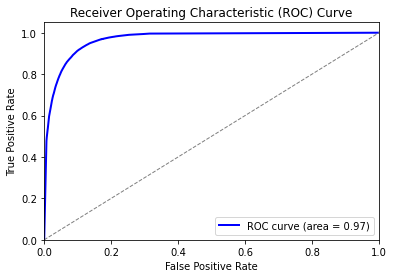

AUC: 0.97


In [20]:
import matplotlib.pyplot as plt


# Predict probabilities for the test set
y_probs = best_bag_model.predict_proba(x_test_scaled_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)  # Adjust if y_test is binarized

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print(f"AUC: {roc_auc:0.2f}")

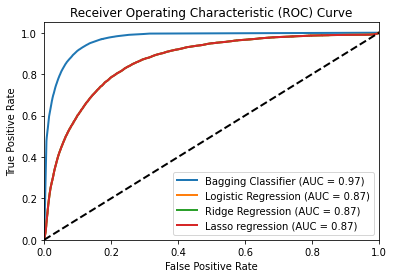

In [22]:
# Initialize models
models = {
    'Bagging Classifier': best_bag_model,
    'Logistic Regression': logreg_model,
    'Ridge Regression': best_ridge_model,
    'Lasso regression' : best_lasso_model
}

# Fit models and compute ROC curves
plt.figure()

for name, model in models.items():
    model.fit(x_train_scaled_pca, y_train)
    y_probs = model.predict_proba(x_test_scaled_pca)[:, 1]  # Probabilities for the positive class

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:0.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Since we have 3 principal components, a 3d graph was rendered.

#### *PCA components explained*

Let's see how much of each feature influenced the principal components.


In [ ]:
pca_scaled = PCA(n_components=3)
new_X_train_scaled_pca = pca_scaled.fit_transform(x_train_scaled)
components = pca_scaled.components_
evr = pca_scaled.explained_variance_ratio_

loadings_scaled = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=[x_train_scaled.columns])
# Sort each column in ascending order
sorted_loadings_scaled = loadings_scaled.apply(lambda x: x.sort_values())

print("\nSorted Loadings Scaled:")
print(sorted_loadings_scaled)

# Print sorted values for each PC individually
for i in range(components.shape[0]):
    sorted_pc = loadings_scaled[f'PC{i+1}'].sort_values(ascending=True)
    print(f"\nSorted Loadings for PC{i+1}:")
    print(sorted_pc)

In [ ]:
# Sort and select top 20 features for each component, can change if needed
top_features_per_pc = {}
num_top_features = 20

for pc in loadings_scaled.columns:
    top_features = loadings_scaled[pc].abs().sort_values(ascending=False).head(num_top_features).index
    top_features_per_pc[pc] = top_features

# Get unique top features
unique_top_features = list(set([feature for features in top_features_per_pc.values() for feature in features]))

# Filter DataFrame to include only top features
loadings_scaled_top = loadings_scaled.loc[unique_top_features]

# Perform hierarchical clustering on top features
Z = linkage(loadings_scaled_top, 'ward')

# Plot clustered heatmap
sns.clustermap(loadings_scaled_top, annot=True, cmap='coolwarm', linewidths=0.5, figsize=(20, 15), row_cluster=True, col_cluster=False)
plt.title('Heatmap of Top Feature Contributions to Principal Components with Clustering')
plt.show()

According to this visualization, within the top 20 features, the 6 that stand out are total payment, number of users, number of providers, average number of providers per county, number of fee for service benficiaries and average number of users per provider.